In [ ]:
%pip install -q pystac_client contextily

In [108]:
import gc

from tqdm.auto import tqdm, trange
import numpy as np
import torch
from shapely.geometry import mapping, shape
import geopandas as gpd
import contextily as cx
import pystac_client
from matplotlib import pyplot as plt
from matplotlib import patches
from rastervision.core.box import Box
from rastervision.core.data import XarraySource

In [8]:
BANDS = [
    'coastal', # B01
    'blue', # B02
    'green', # B03
    'red', # B04
    'rededge1', # B05
    'rededge2', # B06
    'rededge3', # B07
    'nir', # B08
    'nir08', # B8A
    'nir09', # B09
    'swir16', # B11
    'swir22', # B12
]
len(BANDS)

12

## Find images

In [5]:
URL = 'https://earth-search.aws.element84.com/v1'
catalog = pystac_client.Client.open(URL)

In [200]:
# pakistan flood
# bbox = Box(ymin=27.928302071710085, xmin=67.5765791347513, ymax=27.882622897292368, xmax=67.62918549065832)
# turkey earthquake
# bbox = Box(ymin=36.223109, xmin=36.132110, ymax=36.185930, xmax=36.175093)
# glacier bay, AK
30.830462, 79.112596
30.728054, 79.273832

bbox = Box(ymin=30.736607667297868, xmin=79.1178517046199, ymax=30.604705989795637, xmax=79.16440162515337)
bbox

Box(ymin=30.736607667297868, xmin=79.1178517046199, ymax=30.604705989795637, xmax=79.16440162515337)

In [201]:
bbox_geom = bbox.to_shapely()
bbox_geometry = mapping(bbox_geom.oriented_envelope)

In [136]:
items = catalog.search(
    intersects=bbox_geometry,
    collections=['sentinel-2-l2a'],
    datetime='2017-01-01/2024-12-31',
    query={'eo:cloud_cover': {'lt': 5}},
).item_collection()
items = items[::-1]
len(items)

190

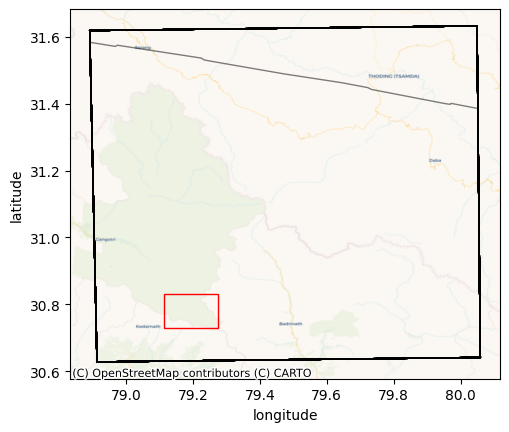

In [191]:
gdf = gpd.GeoDataFrame.from_features(items)
fig, ax = plt.subplots()
gdf.plot(ax=ax, ec='k', fc='none', alpha=0.5)
bbox_patch = patches.Polygon(np.array(bbox.to_points()), ec='r', fc='none')
ax.add_patch(bbox_patch)
ax.autoscale()
cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.CartoDB.Voyager)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
plt.show()

In [150]:
within_flags = [bbox_geom.within(shape(item.geometry)) for item in tqdm(items)]
sum(within_flags)

  0%|          | 0/190 [00:00<?, ?it/s]

129

In [151]:
items = [item for item in tqdm(items) if bbox_geom.within(shape(item.geometry))]
len(items)

  0%|          | 0/190 [00:00<?, ?it/s]

129

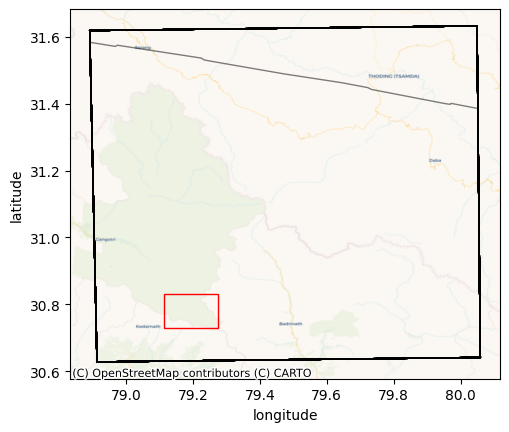

In [192]:
gdf = gpd.GeoDataFrame.from_features(items)
fig, ax = plt.subplots()
gdf.plot(ax=ax, ec='k', fc='none', alpha=0.5)
bbox_patch = patches.Polygon(np.array(bbox.to_points()), ec='r', fc='none')
ax.add_patch(bbox_patch)
cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.CartoDB.Voyager)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
plt.show()

### Convert to a Raster Vision `RasterSource`

In [202]:
raster_source = XarraySource.from_stac(
    items,
    temporal=True,
    allow_streaming=True,
    bbox_map_coords=bbox,
    stackstac_args=dict(
        assets=BANDS, 
        rescale=False, 
        dtype=np.uint16, 
        fill_value=0,
        epsg=32636, # turkey
    ),
)
raster_source.shape, raster_source.dtype

((129, 800, 800, 12), dtype('uint16'))

In [199]:
crs_tf = raster_source.crs_transformer
crs_tf.pixel_to_map(Box(ymin=400, xmin=0, ymax=1200, xmax=800), bbox=raster_source.bbox)

Box(ymin=30.736607667297868, xmin=79.1178517046199, ymax=30.604705989795637, xmax=79.16440162515337)

In [203]:
dates = np.array([str(t.date()) for t in raster_source.data_array.time.to_series()])

In [204]:
chip = raster_source[0,]
chip.shape

(800, 800, 12)

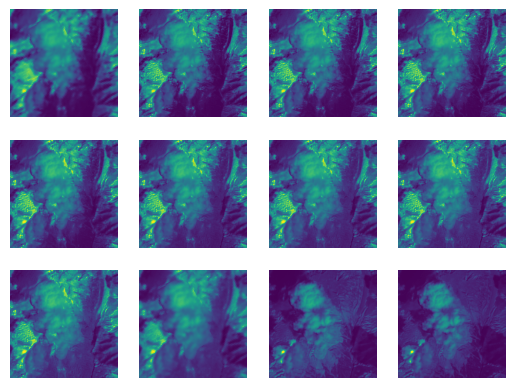

In [205]:
fig, axs = plt.subplots(3, 4)
for band, ax in zip(chip.transpose(2, 0, 1), axs.flat):
    ax.imshow(band[:400, :400])
    ax.axis('off')
plt.show()

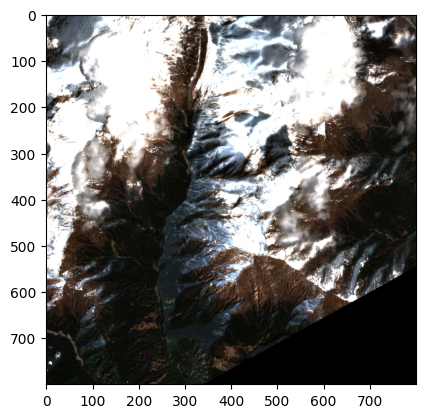

In [208]:
plt.imshow(chip[..., [3, 2, 1]] / 5_000)
plt.show()

## Download

In [109]:
del chips
gc.collect()

157478

In [110]:
chips = np.empty(raster_source.shape, dtype=raster_source.dtype)
chips.shape

(378, 400, 400, 12)

In [111]:
T, *_ = raster_source.shape
with tqdm(dates) as bar:
    for t, date in enumerate(bar):
        bar.set_postfix_str(date)
        chips[t] = raster_source[t, ...]    

  0%|          | 0/378 [00:00<?, ?it/s]

In [112]:
chips_data = dict(
    chips=chips, 
    dates=dates, 
)
torch.save(chips_data, 'data/chips_s2_trquake.pt')